# Desarrollo del Modelo de Clasificación para predicción de Diabetes

Durante el proceso de desarrollo de nuestro modelo predictivo, evaluamos diversos algoritmos de ensamble, entre ellos:

- RandomForest
- XGBoost
- LightGBM
- GradientBoosting
- LogisticRegression

Uno de los principales desafíos fue el fuerte desbalanceo del dataset, con la siguiente distribución de clases:

- No diabetes (0): 213,703 registros (84.2%)

- Prediabetes (1): 4,631 registros (1.8%)

- Diabetes (2): 35,346 registros (13.9%)

Este desequilibrio afectaba significativamente el rendimiento del modelo, particularmente en la clase de Prediabetes, donde algunos modelos llegaban a presentar un recall de 0, es decir, no lograban identificar correctamente ningún caso de esta clase.



También probamos a eliminar las filas duplicadas que habíamos encontrado pero las métricas no mejoraban, por lo que decidimos dejarlos presentes.

Además, probamos eliminar algunas variables que tenían <0.01 de correlación con la variable target, pero tampoco presentaban una gran mejoría al eliminarlas, por lo que decidimos dejarlas pensando que pueden influir mínimamente pero de forma positiva en la predicción.

Se puede ver todos los modelos que hemos ido probando en las ramas:
- feature/eda-v1
- feature/eda-2
- feature/eda-v3
- feature/eda-v4

Pero para tener un codigo limpio, hemos decidio traer a esta versión final feature/model , el modelo que hemos elegido ya que tiene las mejores métricas.

## Modelo seleccionado: LightGBM

Después de múltiples pruebas, seleccionamos LightGBM como modelo final debido a su mejor equilibrio entre precisión general y capacidad para detectar casos de prediabetes, utilizando los siguientes parámetros:

```
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    class_weight=class_weights,  # pesos calculados automáticamente
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)
```

El conjunto de datos fue dividido en entrenamiento y prueba con estratificación para preservar la distribución original de clases.

## Nuestro modelo con LightGBM

In [4]:
!pip install -q lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
🔍 Resultados para: LightGBM
✅ Accuracy: 0.6390137180700095
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9529    0.6467    0.7705     42741
           1     0.0282    0.2527    0.0508       926
           2     0.3383    0.6429    0.4433      7069

    accuracy                         0.6390     50736
   macro avg     0.4398    0.5141    0.4215     50736
weighted avg     0.8504    0.6390    0.7118     50736



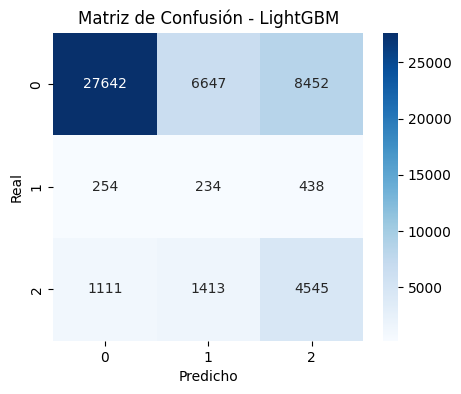

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import pandas as pd

df = pd.read_csv('../data/diabetes-db.csv')

# cargamos los datos en sus respectivas variables
X = df.drop(columns=['Diabetes_012'])
y = df['Diabetes_012'].astype(int)

# dividimos los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    
    print(f"🔍 Resultados para: {nombre}")
    print("✅ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()
    
# LightGBM
from collections import Counter
counter = Counter(y_train)
total = sum(counter.values())
class_weights = {cls: total/count for cls, count in counter.items()}

lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    class_weight=class_weights,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)
lgbm.fit(X_train, y_train)
evaluar_modelo(lgbm, "LightGBM")

## Overfitting < 5%

In [5]:
# Predicciones en entrenamiento
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("✅ Accuracy en entrenamiento:", train_acc)
print("✅ Accuracy en prueba:", test_acc)


print("📋 Classification Report - Entrenamiento:")
print(classification_report(y_train, y_train_pred, digits=4))

print("📋 Classification Report - Prueba:")
print(classification_report(y_test, y_test_pred, digits=4))


# Diferencia
gap = train_acc - test_acc
print(f"🔍 Overfitting (train - test): {gap:.4f}")

✅ Accuracy en entrenamiento: 0.6555059523809523
✅ Accuracy en prueba: 0.6390137180700095
📋 Classification Report - Entrenamiento:
              precision    recall  f1-score   support

           0     0.9616    0.6496    0.7754    170962
           1     0.0732    0.6629    0.1319      3705
           2     0.3621    0.6905    0.4751     28277

    accuracy                         0.6555    202944
   macro avg     0.4656    0.6677    0.4608    202944
weighted avg     0.8618    0.6555    0.7218    202944

📋 Classification Report - Prueba:
              precision    recall  f1-score   support

           0     0.9529    0.6467    0.7705     42741
           1     0.0282    0.2527    0.0508       926
           2     0.3383    0.6429    0.4433      7069

    accuracy                         0.6390     50736
   macro avg     0.4398    0.5141    0.4215     50736
weighted avg     0.8504    0.6390    0.7118     50736

🔍 Overfitting (train - test): 0.0165


In [6]:
import joblib

joblib.dump(lgbm, '../model/model_lgbm.pkl')

['../model/model_lgbm.pkl']

### 📌 Conclusión
El modelo final basado en LightGBM, con ajuste de pesos por clase y validación adecuada, cumple con los criterios de aceptación del equipo:

✅ Accuracy > 60%

✅ Recall de Prediabetes > 20%

✅ Overfitting < 5%

Esto nos permite tener confianza en su capacidad para identificar correctamente los casos de diabetes y, crucialmente, mejorar la detección temprana de la prediabetes, que era una de las mayores debilidades del modelo inicial.

